# **Deep Learning Methods. Second task.**
Author: Armantas Pikšrys

LSP: 2016018

## Download images

In [ ]:
!pip install openimages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 4.8 MB/s eta 0:00:00


In [ ]:
import os
from openimages.download import download_dataset

In [ ]:
data_dir = "data"
image_amount_per_class = 1000
classes = ["Animal", "Boat", "Car"]

In [ ]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
    print("Downloading is starting...")
    download_dataset(data_dir, classes, limit = image_amount_per_class)

100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s]


## Custom Dataset

In [ ]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
import numpy as np
from glob import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import label2rgb

In [ ]:
# Creation of Custom dataset

class CustomDataset(Dataset):
    def __init__(self, images_dir, transforms = None):
        self.images_dir = images_dir
        self.transforms = transforms

        self.class1_files = glob(images_dir + "/{}/images/*.jpg".format(classes[0].lower()))
        self.class2_files = glob(images_dir + "/{}/images/*.jpg".format(classes[1].lower()))
        self.class3_files = glob(images_dir + "/{}/images/*.jpg".format(classes[2].lower()))
        
        self.class1 = len(self.class1_files)
        self.class2 = len(self.class2_files)
        self.class3 = len(self.class3_files)

        self.files = self.class1_files + self.class2_files + self.class3_files

        # Set labels for each file
        self.labels = np.zeros(len(self.files))
        self.labels[self.class1:(self.class1 + self.class2)] = 1
        self.labels[(self.class1 + self.class2):] = 2

        self.labels = [int(x) for x in self.labels]

        # Shuffle
        self.order =  [x for x in np.random.permutation(len(self.labels))]

        self.files = [self.files[x] for x in self.order]
        self.labels = [self.labels[x] for x in self.order]


    def __len__(self):
        return (len(self.labels))


    def __getitem__(self, i):
        file_path = self.files[i]
        image = Image.open(file_path)
        img_tensor = image.convert('RGB')
        
        if self.transforms is not None:
           img_tensor = self.transforms(img_tensor)

        label = torch.tensor(self.labels[i])

        return (img_tensor, label)   

In [ ]:
# Test dataset
dataset = CustomDataset("./data")
print(dataset.__len__())

3000


## Define transforms

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

## Load data using Dataloader

In [ ]:
from torch.utils.data import DataLoader, random_split

In [ ]:
# Compute the sizes of the three datasets
dataset = CustomDataset("./data", transforms = transformer)
total_size = len(dataset)
train_size = int(total_size * 0.7) # 70%
test_size = int(total_size * 0.3) # 30%

# Use random_split to split the dataset into two parts
data_train, data_test = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(data_train)}")
print(f"Test size: {len(data_test)}")

Train size: 2100
Test size: 900


In [ ]:
batch_size = 64

# Define the data loaders
train_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(data_test, batch_size = batch_size, shuffle = True)

In [ ]:
print(data_train.__getitem__(0)[0].shape)

torch.Size([3, 128, 128])


## Convolutional Neural Network

In [ ]:
from torch import nn

In [ ]:
class ConvModel(nn.Module):
    def __init__(self, num_classes = 3):
        super(ConvModel, self).__init__()

        #Input shape = (64,3,128,128)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
            #Shape = (256,12,64,64)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
            #Shape = (256,20,64,64)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
            #Shape = (256,32,64,64)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=64 * 64 * 32, out_features=num_classes)
        )
        self.sigmoid = nn.Sequential(
            nn.Sigmoid()
        )
        
    def forward(self, input):
        output = self.layer1(input)
        output = self.layer2(output)
        output = self.layer3(output)
            
        #Above output will be in matrix form, with shape (64,32,64,64)
            
        output = output.view(-1,32*64*64)
            
        output = self.fc(output)
        output = self.sigmoid(output)
            
        return output

## Training the CNN

In [ ]:
from torch.optim import SGD
from torch.autograd import Variable
import torchvision

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = ConvModel().to(device)
print(model)

ConvModel(
  (layer1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=131072, out_features=3, bias=True)
  )
  (sigmoid): Sequential(
    (0): Sigmoid()
  )
)


In [ ]:
# Training variables
learning_rate = 0.001
num_epochs = 10
best_accuracy = 0.0

In [ ]:
# Loss function and optimizer
loss_function = nn.BCELoss()
optimizer = SGD(model.parameters(), lr = learning_rate, momentum=0.7)

In [ ]:
# Model training and saving best model
for epoch in range(num_epochs):

    # Training
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Get output
        outputs = model(images)

        # Convert single label to multi label
        labels_onehot = torch.zeros_like(outputs)
        labels_onehot.scatter_(1, labels.unsqueeze(1), 1.0)

        loss = loss_function(outputs, labels_onehot.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / train_size

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))


Epoch: 1 	Training Loss: 0.572541
Epoch: 2 	Training Loss: 0.475443
Epoch: 3 	Training Loss: 0.424105
Epoch: 4 	Training Loss: 0.397239
Epoch: 5 	Training Loss: 0.365639
Epoch: 6 	Training Loss: 0.328989
Epoch: 7 	Training Loss: 0.303317
Epoch: 8 	Training Loss: 0.289710
Epoch: 9 	Training Loss: 0.270505
Epoch: 10 	Training Loss: 0.255845


## Testing the CNN

In [ ]:
model.eval()

evaluation_results = []

with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)
        predictions = model(data)

        for img_id, class_probs in enumerate(predictions):
            actual_class = labels[img_id]
            evaluation_results.append((class_probs, actual_class))

print(evaluation_results)

[(tensor([0.2392, 0.3925, 0.0899], device='cuda:0'), tensor(2, device='cuda:0')), (tensor([0.0428, 0.5326, 0.3419], device='cuda:0'), tensor(1, device='cuda:0')), (tensor([0.4890, 0.0986, 0.3723], device='cuda:0'), tensor(0, device='cuda:0')), (tensor([0.0335, 0.8335, 0.1013], device='cuda:0'), tensor(1, device='cuda:0')), (tensor([0.8444, 0.5707, 0.0058], device='cuda:0'), tensor(0, device='cuda:0')), (tensor([0.4415, 0.2543, 0.1591], device='cuda:0'), tensor(2, device='cuda:0')), (tensor([0.0043, 0.4296, 0.9066], device='cuda:0'), tensor(1, device='cuda:0')), (tensor([0.2718, 0.1273, 0.7116], device='cuda:0'), tensor(1, device='cuda:0')), (tensor([0.2806, 0.3046, 0.3223], device='cuda:0'), tensor(1, device='cuda:0')), (tensor([0.8405, 0.2295, 0.0338], device='cuda:0'), tensor(0, device='cuda:0')), (tensor([0.4683, 0.4033, 0.1602], device='cuda:0'), tensor(0, device='cuda:0')), (tensor([0.3536, 0.5829, 0.0453], device='cuda:0'), tensor(1, device='cuda:0')), (tensor([0.3455, 0.0429, 0.

## Statistics

### Binary evaluation using thresholds

In [ ]:
thresholds = [0.6, 0.6, 0.6]
binary_evaluation_results = []

def convert_to_binary_list(scores, thresholds):
    binary_list = []
    for i in range(len(scores)):
        if scores[i] > thresholds[i]:
            binary_list.append(1)
        else:
            binary_list.append(0)
    return binary_list

for index, (pred_score, label) in enumerate(evaluation_results):
    binary_evaluation_results.append((convert_to_binary_list(pred_score, thresholds), label))

print(binary_evaluation_results)

[([0, 0, 0], tensor(2, device='cuda:0')), ([0, 0, 0], tensor(1, device='cuda:0')), ([0, 0, 0], tensor(0, device='cuda:0')), ([0, 1, 0], tensor(1, device='cuda:0')), ([1, 0, 0], tensor(0, device='cuda:0')), ([0, 0, 0], tensor(2, device='cuda:0')), ([0, 0, 1], tensor(1, device='cuda:0')), ([0, 0, 1], tensor(1, device='cuda:0')), ([0, 0, 0], tensor(1, device='cuda:0')), ([1, 0, 0], tensor(0, device='cuda:0')), ([0, 0, 0], tensor(0, device='cuda:0')), ([0, 0, 0], tensor(1, device='cuda:0')), ([0, 0, 0], tensor(2, device='cuda:0')), ([1, 0, 0], tensor(0, device='cuda:0')), ([0, 1, 0], tensor(0, device='cuda:0')), ([0, 1, 0], tensor(1, device='cuda:0')), ([0, 0, 1], tensor(2, device='cuda:0')), ([0, 0, 1], tensor(2, device='cuda:0')), ([0, 1, 0], tensor(1, device='cuda:0')), ([0, 0, 1], tensor(2, device='cuda:0')), ([0, 0, 0], tensor(0, device='cuda:0')), ([1, 0, 0], tensor(0, device='cuda:0')), ([0, 0, 0], tensor(1, device='cuda:0')), ([1, 0, 0], tensor(1, device='cuda:0')), ([1, 0, 0], ten

### Confusion matrix for each class and classification report

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, confusion_matrix

In [ ]:
prediction_classes, actual_classes = zip(*binary_evaluation_results)

prediction_classes = list(prediction_classes)
actual_classes = list(actual_classes)

actual_labels = np.zeros((len(prediction_classes), len(classes)), dtype=np.int32)

for i, label_tuple in enumerate(actual_classes):
    label = label_tuple.cpu().tolist()
    actual_labels[i][label] = 1


matrixes = multilabel_confusion_matrix(actual_labels, prediction_classes)
matrixes = np.flip(matrixes)

report = classification_report(actual_labels, prediction_classes, target_names=['Animal', 'Boat', 'Car'])
accuracy_report = accuracy_score(actual_labels, prediction_classes)

print("Animal confusion matrix\n")
print(matrixes[2])
print("\nBoat confusion matrix\n")
print(matrixes[1])
print("\nCar confusion matrix\n")
print(matrixes[0])

print("\nClassification report\n")
print(report)

def calculate_acc(matrix):
    return (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1])

animal_acc = calculate_acc(matrixes[2])
print('Animal accuracy: {:.2f}'.format(animal_acc))

boat_acc = calculate_acc(matrixes[1])
print('Boat accuracy: {:.2f}'.format(boat_acc))

car_acc = calculate_acc(matrixes[0])
print('Car accuracy: {:.2f}'.format(car_acc))

macro_acc = (animal_acc+boat_acc+car_acc) / 3
print('Macro accuracy: {:.2f}'.format(macro_acc))

Animal confusion matrix

[[185 135]
 [ 54 526]]

Boat confusion matrix

[[121 180]
 [ 33 566]]

Car confusion matrix

[[166 113]
 [ 60 561]]

Classification report

              precision    recall  f1-score   support

      Animal       0.77      0.58      0.66       320
        Boat       0.79      0.40      0.53       301
         Car       0.73      0.59      0.66       279

   micro avg       0.76      0.52      0.62       900
   macro avg       0.76      0.53      0.62       900
weighted avg       0.77      0.52      0.62       900
 samples avg       0.52      0.52      0.52       900

Animal accuracy: 0.79
Boat accuracy: 0.76
Car accuracy: 0.81
Macro accuracy: 0.79


### Accuracy, precision, recall, F1 Score manually

In [ ]:
# First we need to calculate the confusion matrix

def get_confusion_matrix_stats(predictions):
    tp, fp, tn, fn = 0, 0, 0, 0

    for pred_classes, actual_class in predictions:
        for index, prediction in enumerate(pred_classes):
            if prediction == 1 and index == actual_class:
                tp += 1
            
            if prediction == 1 and index != actual_class:
                fp += 1

            if prediction == 0 and index == actual_class:
                fn += 1

            if prediction == 0 and index != actual_class:
                tn += 1

    return tp, fp, tn, fn

true_positives, false_positives, true_negatives, false_negatives = get_confusion_matrix_stats(binary_evaluation_results)

In [ ]:
# Calculate accuracy
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

# Calculate precision
precision = true_positives / (true_positives + false_positives)

# Calculate recall
recall = true_positives / (true_positives + false_negatives)

# Calculate f1 score
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score : ", f1_score)

Accuracy:  0.7870370370370371
Precision:  0.7625201938610663
Recall:  0.5244444444444445
F1 Score :  0.6214614878209348


## Test single image

In [ ]:
import matplotlib.pyplot as plt

tensor([[0.0085, 0.0510, 0.9922]], device='cuda:0', grad_fn=<SigmoidBackward0>)


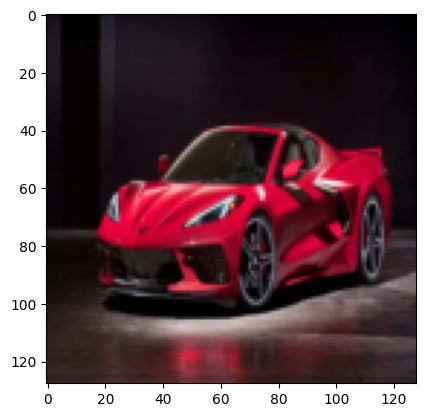

In [ ]:
file_path = './data/test/images/car.jpg'

image = Image.open(file_path)

img_tensor = transformer(image)
img_tensor = img_tensor.to(device)

plt.imshow(img_tensor.cpu().numpy().transpose((1, 2, 0)))

output = model(img_tensor.unsqueeze(0))

print(output)

## Save model

In [ ]:
from google.colab import files

file_name = "model_save.pth"
torch.save(model.state_dict(), file_name)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>